In [1]:
%load_ext autoreload
%autoreload 2

# Proof of concept

In [2]:
# Torch device management
import torch

if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cpu


In [3]:
import embedders

In [8]:
# Load Polblogs

polblogs_dists, polblogs_labels = embedders.dataloaders.load(
    "polblogs",
    labels=True,
    polblogs_path="/Users/phil/embedders/data/graphs/polblogs.mtx",
    polblogs_labels_path="/Users/phil/embedders/data/graphs/polblogs_labels.tsv",
)

Top CC has 1222 nodes; original graph has 1490 nodes.


In [10]:
# Specify signature - useful to re-initialize the manifold here

torch.manual_seed(0)  # Not all seeds are stable - this one trains for 3000 iterations at lr=1e-2 (burn-in 1e-3)

signature = [(-1, 6)]
pm = embedders.manifolds.ProductManifold(signature=signature)
print(pm.name)

# Rescale distances
dists_rescaled = polblogs_dists / polblogs_dists.max()

# Get embedding
embedders.coordinate_learning.train_coords(
    pm,
    dists_rescaled,
    device=device,
    burn_in_iterations=300,
    training_iterations=300 * 9,
    learning_rate=1e-1,
    burn_in_learning_rate=1e-2,
    scale_factor_learning_rate=1e-1,
)

h6_polblogs = pm.x_embed.detach().cpu().numpy()

H_1.0^6


  0%|          | 0/3000 [00:00<?, ?it/s]

In [22]:
# Compare productDT and sklearn on this dataset
# from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# from hyperdt.tree import HyperbolicDecisionTreeClassifier
from embedders.tree_new import ProductSpaceDT
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(h6_polblogs, polblogs_labels.values, test_size=0.2, random_state=0)

pdt = ProductSpaceDT(pm=pm, max_depth=3, use_special_dims=True)
pdt.fit(X_train, y_train)
pdt_f1 = f1_score(y_test, pdt.predict(X_test))
print(f"ProductDT\t{pdt_f1*100:.2f}")

dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
dt_f1 = f1_score(y_test, dt.predict(X_test))
print(f"DT\t{dt_f1*100:.2f}")

ProductDT	89.23
DT	89.31


In [23]:
# Same thing, but now we do H2 x E2 x S2
torch.manual_seed(0)

signature = [(-1, 2), (0, 2), (1, 2)]
pm2 = embedders.manifolds.ProductManifold(signature=signature)
print(pm2.name)

# Get embedding
embedders.coordinate_learning.train_coords(
    pm2,
    dists_rescaled,
    device=device,
    burn_in_iterations=300,
    training_iterations=300 * 9,
    learning_rate=1e-1,
    burn_in_learning_rate=1e-2,
    scale_factor_learning_rate=1e-1,
)

h2_e2_s2_polblogs = pm2.x_embed.detach().cpu().numpy()

H_1.0^2 x E_0.0^2 x S_1.0^2


  0%|          | 0/3000 [00:00<?, ?it/s]

In [24]:
# Compare productDT and sklearn on this dataset
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(
    h2_e2_s2_polblogs, polblogs_labels.values, test_size=0.2, random_state=0
)

pdt2 = ProductSpaceDT(pm=pm2, max_depth=3)
pdt2.fit(X_train, y_train)
pdt2_f1 = f1_score(y_test, pdt2.predict(X_test))
print(f"ProductDT\t{pdt2_f1*100:.2f}")

dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
dt_f1 = f1_score(y_test, dt.predict(X_test))
print(f"DT\t{dt_f1*100:.2f}")
# cv_eval(dt, "DT", h2_e2_s2_polblogs, polblogs_labels)

# TODO: Quentin: product perceptron eval
# TODO: Quentin: product SVM eval

ProductDT	90.57
DT	88.46


In [10]:
# Does it hold up componentwise?

# Hyperbolic
pdt_H = ProductSpaceDT(max_depth=3, signature=[(2, -1.0)])
cv_eval(pdt_H, "ProductDT (H)", h2_e2_s2_polblogs[:, pm2.man2dim[0]], polblogs_labels)

hdt_H = HyperbolicDecisionTreeClassifier(max_depth=3, skip_hyperboloid_check=True)
cv_eval(hdt_H, "HyperDT (H)", h2_e2_s2_polblogs[:, pm2.man2dim[0]], polblogs_labels)

dt_H = DecisionTreeClassifier(max_depth=3)
cv_eval(dt_H, "DT (H)", h2_e2_s2_polblogs[:, pm2.man2dim[0]], polblogs_labels)

# TODO: Quentin: product perceptron eval
# TODO: Quentin: product SVM eval

print()

# Euclidean
# For the euclidean ones, we won't use man2dim because fix_X() breaks it - we'll hardcode 3:6 instead
pdt_E = ProductSpaceDT(max_depth=3, signature=[(2, 0.0)])
cv_eval(pdt_E, "ProductDT (E)", fix_X(h2_e2_s2_polblogs)[:, 3:6], polblogs_labels)

dt_E = DecisionTreeClassifier(max_depth=3)
cv_eval(dt_E, "DT (E)", h2_e2_s2_polblogs[:, pm2.man2dim[1]], polblogs_labels)

# TODO: Quentin: product perceptron eval
# TODO: Quentin: product SVM eval

print()

# Sphere
pdt_S = ProductSpaceDT(max_depth=3, signature=[(2, 1.0)])
cv_eval(pdt_S, "ProductDT (S)", h2_e2_s2_polblogs[:, pm2.man2dim[2]], polblogs_labels)

hdt_S = HyperbolicDecisionTreeClassifier(max_depth=3, skip_hyperboloid_check=True, angle_midpoint_method="bisect")
cv_eval(hdt_S, "HyperDT (S)", h2_e2_s2_polblogs[:, pm2.man2dim[2]], polblogs_labels)

dt_S = DecisionTreeClassifier(max_depth=3)
cv_eval(dt_S, "DT (S)", h2_e2_s2_polblogs[:, pm2.man2dim[2]], polblogs_labels)

# TODO: Quentin: product perceptron eval
# TODO: Quentin: product SVM eval

ProductDT (H)	70.13 +/- 2.41
HyperDT (H)	70.13 +/- 2.41
DT (H)	68.98 +/- 3.30

ProductDT (E)	81.34 +/- 4.06
DT (E)	81.34 +/- 4.06

ProductDT (S)	90.26 +/- 1.02
HyperDT (S)	90.26 +/- 1.02
DT (S)	90.67 +/- 1.59


In [54]:
contributions = embedders.metrics.dist_component_by_manifold(pm2, pm2.x_embed)

# Why don't these add to 100%...?
print(contributions)
print(sum(contributions))

[0.25659456849098206, 0.3267468214035034, 0.4166586697101593]
1.0000000596046448


# Exhaustive benchmark

In [25]:
SIGNATURES = [
    [(-1, 10)],
    [(0, 10)],
    [(1, 10)],
    [(-1, 5), (-1, 5)],
    [(1, 5), (1, 5)],
    [(-1, 5), (1, 5)],
    [(-1, 2), (-1, 2), (-1, 2), (-1, 2), (-1, 2)],
    [(1, 2), (1, 2), (1, 2), (1, 2), (1, 2)],
    [(-1, 2), (-1, 2), (0, 2), (1, 2), (1, 2)],
]

In [36]:
import torch
import embedders
import numpy as np

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [37]:
# Get data

polblogs_dists, polblogs_labels = embedders.dataloaders.load(
    "polblogs",
    labels=True,
    polblogs_path="/Users/phil/embedders/data/graphs/polblogs.mtx",
    polblogs_labels_path="/Users/phil/embedders/data/graphs/polblogs_labels.tsv",
)
dists_rescaled = polblogs_dists / polblogs_dists.max()
dists_rescaled = torch.tensor(dists_rescaled, dtype=torch.float32).to(device)
polblogs_labels = torch.tensor(polblogs_labels.values, dtype=torch.long).to(device)

Top CC has 1222 nodes; original graph has 1490 nodes.


In [43]:
from embedders.tree import TorchProductSpaceDT, TorchProductSpaceRF
from embedders.metrics import d_avg
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import pickle
import os

DOWNSAMPLE = None
ITERS = 3_000
TRIALS = 10

results = []
# with open(f"../data/polblogs_embeddings/results_dict.pkl", "rb") as f:
#     results = pickle.load(f)

for i, signature in enumerate(SIGNATURES):
    for j in range(TRIALS):
        # Skip existing
        if os.path.exists(f"../data/polblogs_embeddings/polblogs_{i}_{j}.npy"):
            continue

        seed = i * TRIALS + j  # Unique seed
        torch.manual_seed(seed)

        # Generate embedding
        pm = embedders.manifolds.ProductManifold(signature=signature).to(device)
        embedders.coordinate_learning.train_coords(
            pm,
            dists_rescaled[:DOWNSAMPLE, :DOWNSAMPLE],
            device=device,
            burn_in_iterations=int(ITERS * 0.1),
            training_iterations=int(ITERS * 0.9),
            learning_rate=1e-1,
            burn_in_learning_rate=1e-2,
            scale_factor_learning_rate=1e-2,
        )

        # Save embeddings
        np.save(
            f"../data/polblogs_embeddings/polblogs_{i}_{j}.npy",
            pm.x_embed.detach().cpu().numpy(),
        )

        # Calculate d_avg
        my_d_avg = d_avg(pm.pdist(pm.x_embed), dists_rescaled[:DOWNSAMPLE, :DOWNSAMPLE]).item()

        # Evaluate
        # kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
        # for train_index, test_index in kfold.split(pm.x_embed):
        #     X_train, X_test = pm.x_embed[train_index], pm.x_embed[test_index]
        #     y_train, y_test = polblogs_labels[train_index], polblogs_labels[test_index]

        #     # ProductDT
        #     # try:
        #     # pdt = TorchProductSpaceDT(max_depth=3, signature=signature)
        #     pdt = ProductSpaceDT(pm=pm, max_depth=3, use_special_dims=True)
        #     pdt.fit(X_train, y_train)
        #     pdt_acc = f1_score(y_test.cpu().numpy(), pdt.predict(X_test).cpu().numpy(), average="micro")
        #     # except Exception as e:
        #     #     pdt_acc = np.nan
        #     #     print(e)

        #     # ProductRF
        #     # try:
        #     prf = TorchProductSpaceRF(n_estimators=12, max_depth=3, signature=signature)
        #     prf.fit(X_train, y_train)
        #     prf_acc = f1_score(y_test.cpu().numpy(), prf.predict(X_test).cpu().numpy(), average="micro")
        #     # except Exception as e:
        #     #     prf_acc = np.nan
        #     #     print(e)

        #     # Switch to numpy
        #     X_train = X_train.detach().cpu().numpy()
        #     X_test = X_test.detach().cpu().numpy()
        #     y_train = y_train.detach().cpu().numpy()
        #     y_test = y_test.detach().cpu().numpy()

        #     # DT
        #     # try:
        #     dt = DecisionTreeClassifier(max_depth=3)
        #     dt.fit(X_train, y_train)
        #     dt_acc = f1_score(y_test, dt.predict(X_test), average="micro")
        #     # except Exception as e:
        #     #     dt_acc = np.nan
        #     #     print(e)

        #     # RF
        #     # try:
        #     rf = RandomForestClassifier(n_estimators=12, max_depth=3)
        #     rf.fit(X_train, y_train)
        #     rf_acc = f1_score(y_test, rf.predict(X_test), average="micro")
        #     # except Exception as e:
        #     #     rf_acc = np.nan
        #     #     print(e)

        #     results.append(
        #         {
        #             "seed": seed,
        #             "signature": signature,
        #             "d_avg": my_d_avg,
        #             "pdt": pdt_acc,
        #             "prf": prf_acc,
        #             "dt": dt_acc,
        #             "rf": rf_acc,
        #         }
        #     )

        #     # Pickle results at every iteration
        #     with open(f"../data/polblogs_embeddings/results_dict.pkl", "wb") as f:
        #         pickle.dump(results, f)

        #     # Print results
        #     print(pdt_acc, prf_acc, dt_acc, rf_acc, my_d_avg)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [7]:
import pandas as pd

results_df = pd.DataFrame(results)
results_df.to_csv(f"/teamspace/studios/this_studio/embedders/data/polblogs_embeddings/results_final.csv", index=False)

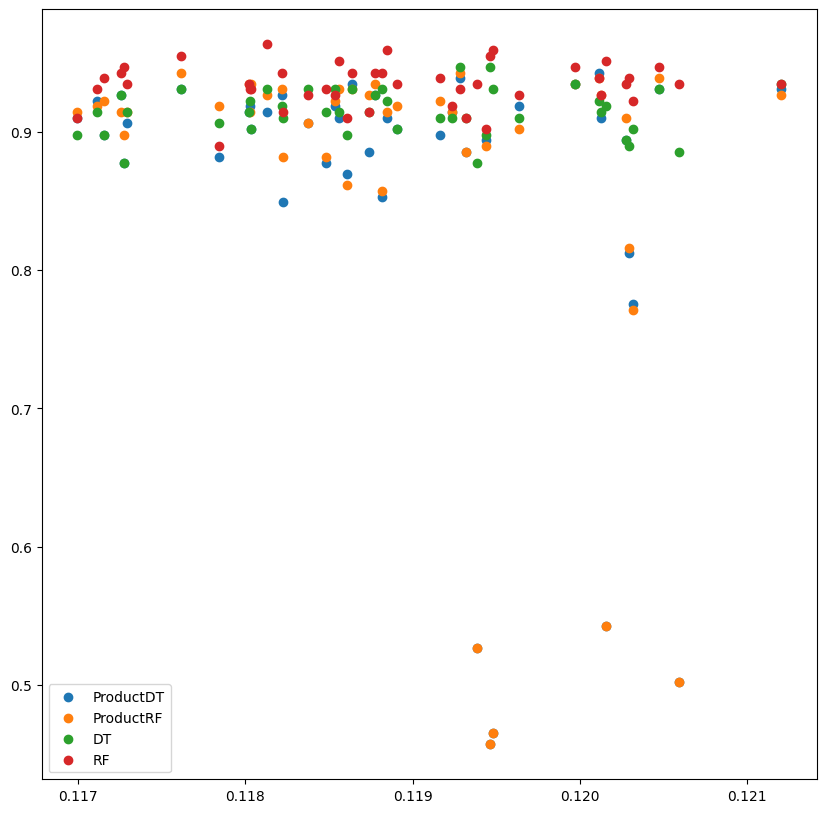

In [15]:
# Scatterplot: d_avg vs. accuracy (each)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
# for i, signature in enumerate(SIGNATURES):
#     results_df_sig = results_df[[x == signature for x in results_df["signature"]]]
plt.scatter(results_df["d_avg"], results_df["pdt"], label=f"ProductDT")
plt.scatter(results_df["d_avg"], results_df["prf"], label=f"ProductRF")
plt.scatter(results_df["d_avg"], results_df["dt"], label=f"DT")
plt.scatter(results_df["d_avg"], results_df["rf"], label=f"RF")
plt.legend()

In [19]:
results_df["signature"] = [str(x) for x in results_df["signature"]]
results_df.groupby("signature").mean()

,seed,d_avg,pdt,prf,dt,rf
signature,,,,,,
"[(-1, 10)]",2.0,0.117168,0.826122,0.833469,0.823673,0.934694
"[(-1, 2), (-1, 2), (-1, 2), (-1, 2), (-1, 2)]",32.0,0.119212,0.916735,0.930612,0.920000,0.937959
"[(-1, 2), (-1, 2), (0, 2), (1, 2), (1, 2)]",42.0,0.118684,0.900408,0.910204,0.915102,0.923265
"[(-1, 5), (-1, 5)]",17.0,0.117578,0.908571,0.925714,0.913469,0.928163
"[(-1, 5), (1, 5)]",27.0,0.119380,0.912653,0.915102,0.920816,0.928980
"[(0, 10)]",7.0,0.119816,0.498776,0.498776,0.911837,0.946939
"[(1, 10)]",12.0,0.119477,0.851429,0.857959,0.902857,0.927347
"[(1, 2), (1, 2), (1, 2), (1, 2), (1, 2)]",37.0,0.118968,0.915102,0.915102,0.924898,0.931429
"[(1, 5), (1, 5)]",22.0,0.119237,0.902857,0.909388,0.920000,0.947755


# Fix Euclidean values

In [13]:
# Ok - I fixed it. The best_theta computations were wrong. Now we need to go through and fix anything that has a Euclidean component

from embedders.tree import TorchProductSpaceDT, TorchProductSpaceRF
from embedders.metrics import d_avg
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import pickle
import os
import numpy as np
import torch
import embedders
import pandas as pd
from tqdm.notebook import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Manifodls
SIGNATURES = [
    [(-1, 10)],
    [(0, 10)],
    [(1, 10)],
    [(-1, 5), (-1, 5)],
    [(1, 5), (1, 5)],
    [(-1, 5), (1, 5)],
    [(-1, 2), (-1, 2), (-1, 2), (-1, 2), (-1, 2)],
    [(1, 2), (1, 2), (1, 2), (1, 2), (1, 2)],
    [(-1, 2), (-1, 2), (0, 2), (1, 2), (1, 2)],
]

# Get data
polblogs_dists, polblogs_labels = embedders.dataloaders.load("polblogs", labels=True)
dists_rescaled = polblogs_dists / polblogs_dists.max()
dists_rescaled = torch.tensor(dists_rescaled, dtype=torch.float32).to(device)
polblogs_labels = torch.tensor(polblogs_labels.values, dtype=torch.long).to(device)

# Get results
results_df = pd.read_csv(f"/teamspace/studios/this_studio/embedders/data/polblogs_embeddings/results_final.csv")

DOWNSAMPLE = None
ITERS = 3000

my_tqdm = tqdm(total=10)
for i in [1, 8]:
    for j in range(5):
        X = np.load(f"/teamspace/studios/this_studio/embedders/data/polblogs_embeddings/polblogs_{i}_{j}.npy")
        X = torch.tensor(X).to(device)

        seed = i * 5 + j  # Unique seed

        signature = SIGNATURES[i]

        # Evaluate
        kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
        for train_index, test_index in kfold.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = polblogs_labels[train_index], polblogs_labels[test_index]

            # ProductDT
            try:
                pdt = TorchProductSpaceDT(max_depth=3, signature=signature)
                pdt.fit(X_train, y_train)
                pdt_acc = f1_score(y_test.cpu().numpy(), pdt.predict(X_test).cpu().numpy(), average="micro")
            except Exception as e:
                pdt_acc = np.nan
                print(e)

            # ProductRF
            try:
                prf = TorchProductSpaceRF(n_estimators=12, max_depth=3, signature=signature)
                prf.fit(X_train, y_train)
                prf_acc = f1_score(y_test.cpu().numpy(), prf.predict(X_test).cpu().numpy(), average="micro")
            except Exception as e:
                prf_acc = np.nan
                print(e)

            # Switch to numpy
            X_train = X_train.detach().cpu().numpy()
            X_test = X_test.detach().cpu().numpy()
            y_train = y_train.detach().cpu().numpy()
            y_test = y_test.detach().cpu().numpy()

            # DT
            try:
                dt = DecisionTreeClassifier(max_depth=3)
                dt.fit(X_train, y_train)
                dt_acc = f1_score(y_test, dt.predict(X_test), average="micro")
            except Exception as e:
                dt_acc = np.nan
                print(e)

            # RF
            try:
                rf = RandomForestClassifier(n_estimators=12, max_depth=3)
                rf.fit(X_train, y_train)
                rf_acc = f1_score(y_test, rf.predict(X_test), average="micro")
            except Exception as e:
                rf_acc = np.nan
                print(e)

            # Go into the dataframe and edit it - recall that signature elements are lists so we have to be weird about it
            # idx = results_df[(results_df["seed"] == seed) & ([x == SIGNATURES[i] for results_df["signature"]])].index[0]
            idx = results_df[(results_df["seed"] == seed)].index[0]
            results_df.at[idx, "pdt"] = pdt_acc
            results_df.at[idx, "prf"] = prf_acc
            results_df.at[idx, "dt"] = dt_acc
            results_df.at[idx, "rf"] = rf_acc

            my_tqdm.update(1)
            my_tqdm.set_description(f"Polblogs {i}_{j}, {pdt_acc:.2f}, {prf_acc:.2f}, {dt_acc:.2f}, {rf_acc:.2f}")

            # Actually, let's just do one iteration for now
            break

Top CC has 1222 nodes; original graph has 1490 nodes.


/tmp/ipykernel_765219/2216669535.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dists_rescaled = torch.tensor(dists_rescaled, dtype=torch.float32).to(device)


  0%|          | 0/10 [00:00<?, ?it/s]

Fallback triggered at depth 2
Fallback triggered at depth 2
Fallback triggered at depth 2
Fallback triggered at depth 2
Fallback triggered at depth 2
Fallback triggered at depth 2
Fallback triggered at depth 2
Fallback triggered at depth 2
Fallback triggered at depth 2
Fallback triggered at depth 2
Fallback triggered at depth 2
Fallback triggered at depth 2
Fallback triggered at depth 2
Fallback triggered at depth 2
Fallback triggered at depth 2
Fallback triggered at depth 2
Fallback triggered at depth 2
Fallback triggered at depth 2
Fallback triggered at depth 2


In [14]:
# Overwrite results table

results_df.to_csv(f"/teamspace/studios/this_studio/embedders/data/polblogs_embeddings/results_final.csv", index=False)

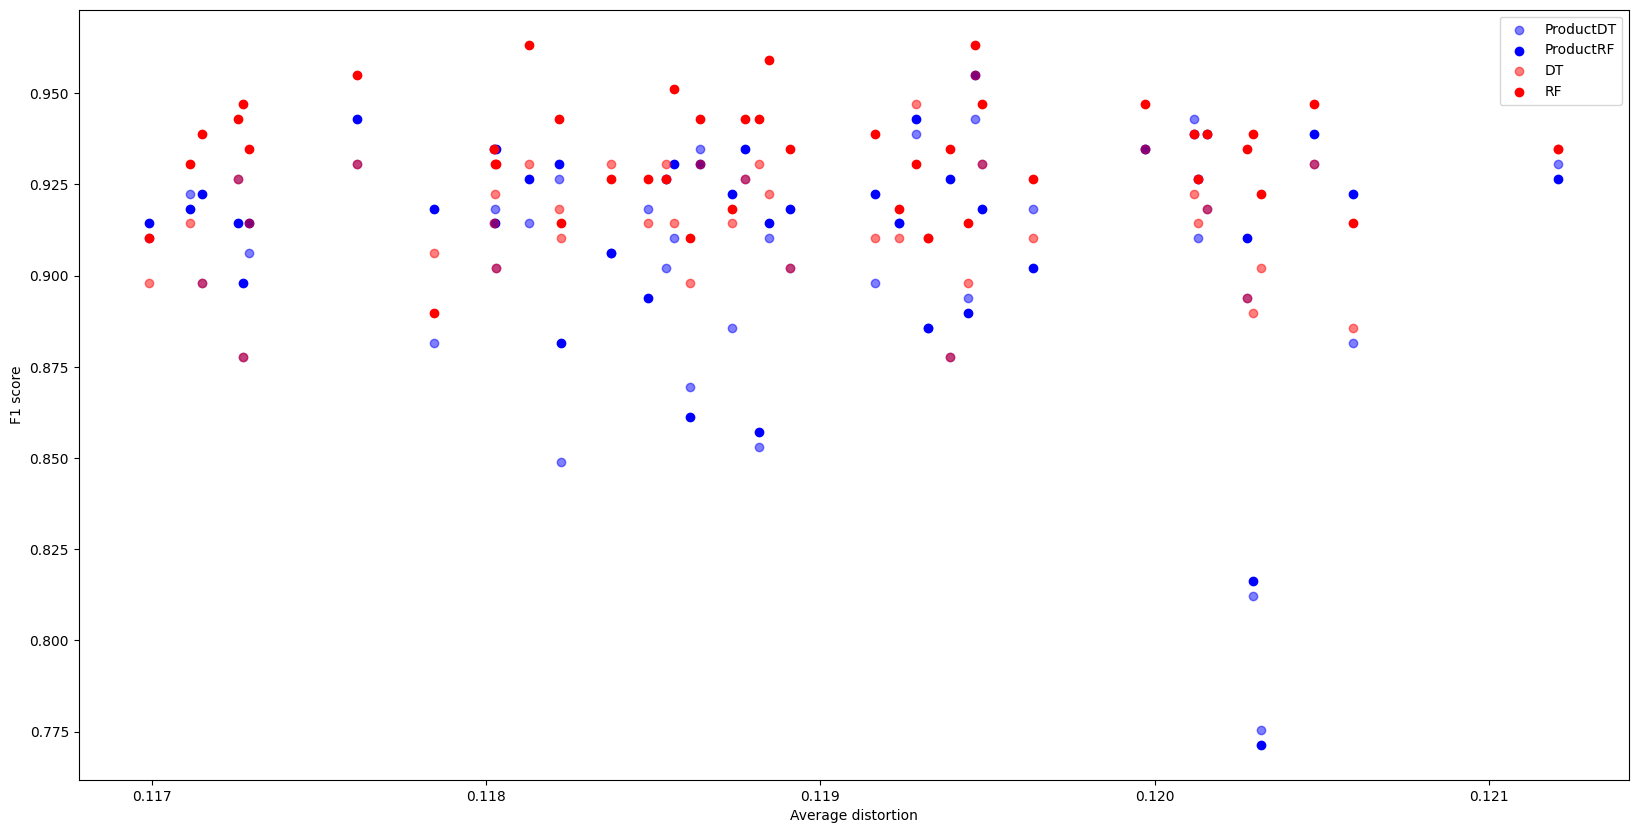

In [17]:
# Re-do scatter plot

# Scatterplot: d_avg vs. accuracy (each)
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
# for i, signature in enumerate(SIGNATURES):
#     results_df_sig = results_df[[x == signature for x in results_df["signature"]]]
plt.scatter(results_df["d_avg"], results_df["pdt"], label=f"ProductDT", c="blue", alpha=0.5)
plt.scatter(results_df["d_avg"], results_df["prf"], label=f"ProductRF", c="blue")
plt.scatter(results_df["d_avg"], results_df["dt"], label=f"DT", c="red", alpha=0.5)
plt.scatter(results_df["d_avg"], results_df["rf"], label=f"RF", c="red")
plt.legend()

# Plot some lines of best fit
from sklearn.linear_model import LinearRegression

plt.plot()

# Axes
plt.xlabel("Average distortion")
plt.ylabel("F1 score")

plt.show()